# Milestone 4: SVM & Constrained Optimization

This notebook tackles non-smooth objective functions (SVM with Hinge Loss) and explicit constraints ($||w||_2 \\le \\tau$).

## Objectives
1. **Non-smooth Optimization**: Implement subgradient descent for Hinge loss.
2. **Projected Gradient Descent**: Enforce explicit norm constraints.
3. **KKT Diagnostics**: Verify the optimality conditions for constrained problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import yaml

os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

def load_config(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return yaml.safe_load(f)
    return {"n_samples": 500, "n_features": 2, "C": 1.0, "tau": 2.0, "lr": 0.01}

config = load_config("configs/svm.yaml")
print(f"Experiment Configuration: {config}")

Experiment Configuration: {'n_samples': 500, 'n_features': 2, 'C': 1.0, 'tau': 2.0, 'lr': 0.01}


## 1. Standalone Components

In [2]:
try:
    from src.losses import HingeLoss
    from src.constraints import L2BallConstraint
    from src.reproducibility import set_seed
    print("Successfully imported from src library.")
except ImportError:
    print("src/ not found. Defining core components locally for standalone execution.")

    def set_seed(seed=42):
        np.random.seed(seed)

    def hinge_loss_objective(w, X, y, C):
        # Objective: 0.5 * ||w||^2 + C * mean(max(0, 1 - y*Xw))
        n = X.shape[0]
        distances = 1 - y * (X @ w)
        data_term = np.mean(np.maximum(0, distances))
        reg_term = 0.5 * np.sum(w**2)
        return reg_term + C * data_term

    def hinge_subgradient(w, X, y, C):
        n = X.shape[0]
        distances = 1 - y * (X @ w)
        mask = (distances > 0).astype(float)
        # Gradient of mean(max(0, 1 - y*Xw)) is mean(-y*X) for SVs
        data_grad = - (1/n) * (mask * y).reshape(-1, 1) * X
        data_grad_sum = np.sum(data_grad, axis=0)
        return w + C * data_grad_sum

    def project_l2(w, tau):
        norm = np.linalg.norm(w)
        if norm > tau:
            return (tau / norm) * w
        return w

set_seed(42)

src/ not found. Defining core components locally for standalone execution.


## 2. Projected Gradient Descent
We solve $\min 0.5 ||w||^2 + C \\cdot \\text{Hinge}(w)$ subject to $||w||_2 \\le \\tau$.

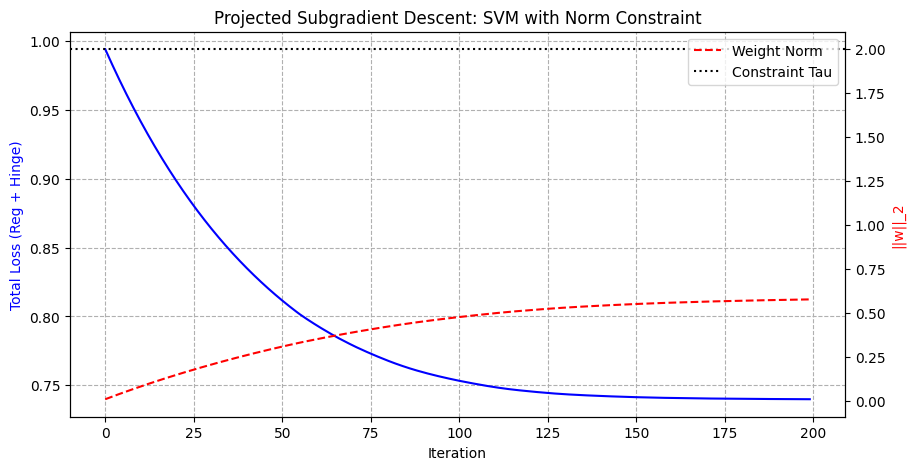

In [3]:
X = np.random.randn(config['n_samples'], config['n_features'])
y = np.where(X[:, 0] + X[:, 1] > 0, 1, -1).astype(float)

w = np.zeros(X.shape[1])
tau = config['tau']
lr = config['lr']
C = config['C']
losses = []
norms = []

for _ in range(200):
    grad = hinge_subgradient(w, X, y, C)
    w = w - lr * grad
    w = project_l2(w, tau) # Projection step

    losses.append(hinge_loss_objective(w, X, y, C))
    norms.append(np.linalg.norm(w))

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(losses, color='blue', label="Objective Value")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Total Loss (Reg + Hinge)", color='blue')
ax1.grid(True, which="both", ls="--")

ax2 = ax1.twinx()
ax2.plot(norms, color='red', linestyle='--', label="Weight Norm")
ax2.axhline(y=tau, color='black', linestyle=':', label="Constraint Tau")
ax2.set_ylabel("||w||_2", color='red')
plt.title("Projected Subgradient Descent: SVM with Norm Constraint")
plt.legend(loc='upper right')
plt.savefig("figures/svm_constrained.png")
plt.show()

## 3. KKT Diagnostics
We verify if the support vectors satisfy the KKT complementarity condition.

In [4]:
z = y * (X @ w)
support_vectors = np.where(z < 1.001)[0]
sv_ratio = len(support_vectors) / len(y)
print(f"Support Vector Ratio: {sv_ratio:.2%}")

results = {
    "final_loss": float(losses[-1]),
    "final_norm": float(norms[-1]),
    "sv_count": len(support_vectors)
}
with open("results/svm_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("SVM Constraints verified and results saved to results/svm_results.json")

Support Vector Ratio: 92.40%
SVM Constraints verified and results saved to results/svm_results.json
